In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

In [ ]:
#데이터 load

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

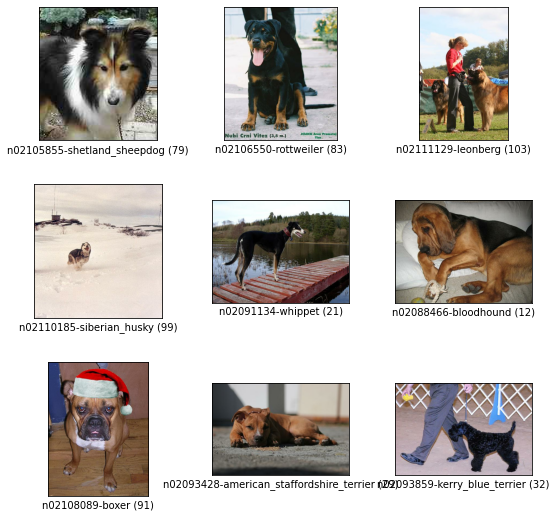

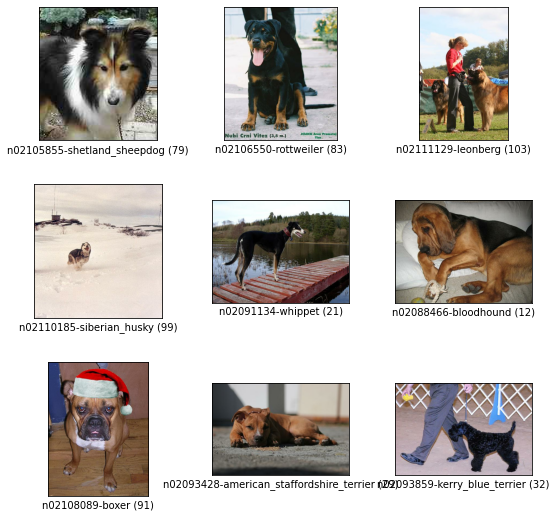

In [3]:
tfds.show_examples(ds_train, ds_info)

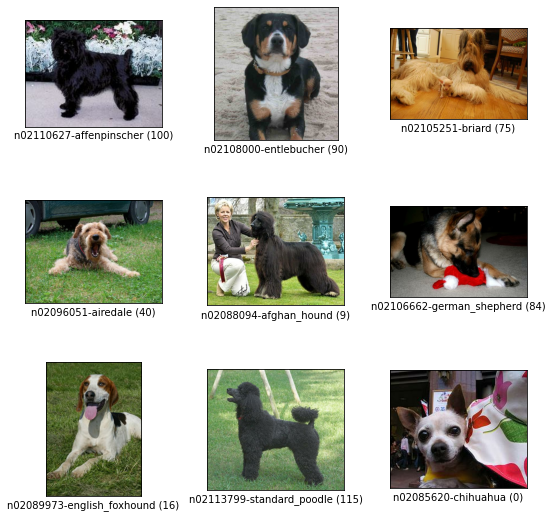

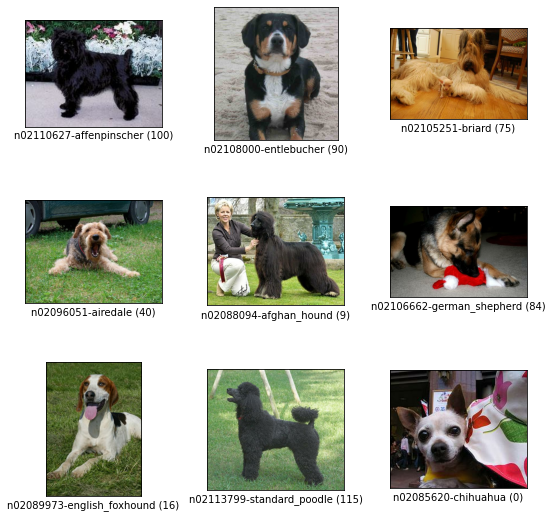

In [4]:
tfds.show_examples(ds_test, ds_info)

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [ ]:
#모델 설계

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes,activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [10]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
#모델 학습

In [11]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 161s 205ms/step - loss: 2.2462 - accuracy: 0.4365 - val_loss: 3.0034 - val_accuracy: 0.2687
Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 0.6493 - accuracy: 0.8263 - val_loss: 1.1759 - val_accuracy: 0.6571
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.1769 - accuracy: 0.9735 - val_loss: 0.9935 - val_accuracy: 0.7083
Epoch 4/20
750/750 [==============================] - 155s 206ms/step - loss: 0.0603 - accuracy: 0.9957 - val_loss: 0.9814 - val_accuracy: 0.7220
Epoch 5/20
750/750 [==============================] - 155s 206ms/step - loss: 0.0288 - accuracy: 0.9992 - val_loss: 0.9449 - val_accuracy: 0.7339
Epoch 6/20
750/750 [==============================] - 170s 226ms/step - loss: 0.0198 - accuracy: 0.9994 - val_loss: 0.9691 - val_accuracy: 0.7309
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0151 - accuracy: 0.9995 - val_loss: 0.9676 -

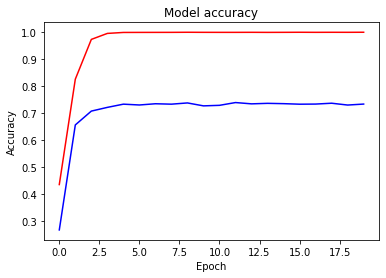

In [17]:
plt.plot(history_cam_model.history['accuracy'], 'r')
plt.plot(history_cam_model.history['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

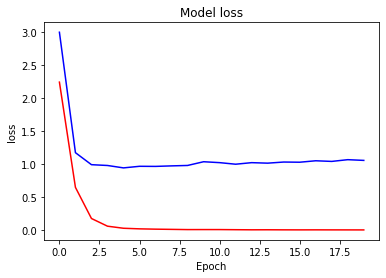

In [18]:
plt.plot(history_cam_model.history['loss'], 'r')
plt.plot(history_cam_model.history['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
#활성맵확인

In [231]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

116


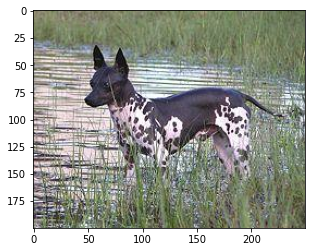

In [232]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [233]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

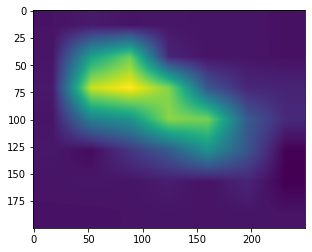

In [234]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [235]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image


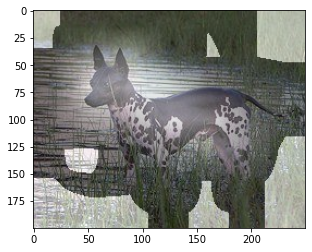

In [236]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [237]:
#

In [238]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [239]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [240]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [241]:
rect = get_bbox(cam_image)
rect

array([[ -7, 100],
       [ 41, -11],
       [257,  82],
       [208, 194]])

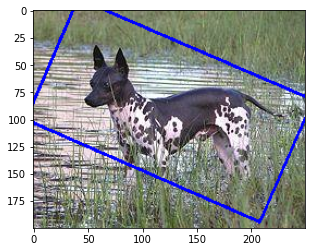

In [242]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [243]:
origin_image.shape

(200, 250, 3)

In [244]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.055, -0.028, 0.97, 1.028]

In [245]:
item['objects']['bbox']

array([[0.165, 0.192, 0.8  , 0.924]], dtype=float32)

In [ ]:
#iou 계산

In [246]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4294345875360837

In [ ]:
#라벨 데이터와 비교

In [247]:
green_bbox = (item['objects']['bbox']*255)[0]

In [248]:
green_bbox = [(green_bbox[0],green_bbox[1]),
                (green_bbox[2],green_bbox[3])]

In [249]:
green_bbox

[(42.075, 48.96), (204.0, 235.62001)]

In [250]:
for idx, i in enumerate(green_bbox):
    green_bbox[idx] = list(map(int, i)) 

In [251]:
green_bbox

[[42, 48], [204, 235]]

In [252]:
img = cv2.rectangle(image, green_bbox[0], green_bbox[1], (0,255,0), 3)

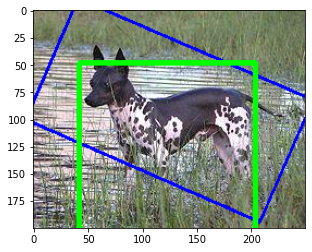

In [253]:
plt.imshow(img)
plt.show()

In [254]:
#활성맵 확인

84


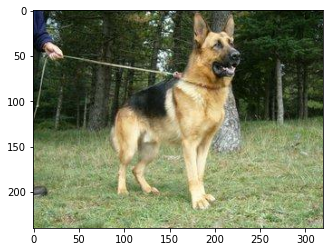

In [345]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [346]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

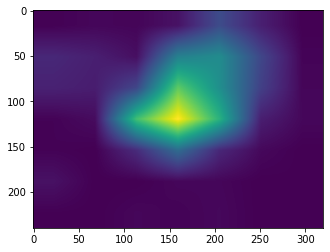

In [347]:
grad_cam_image5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image5)
plt.show()

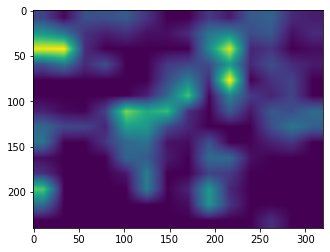

In [348]:
grad_cam_image4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image4)
plt.show()

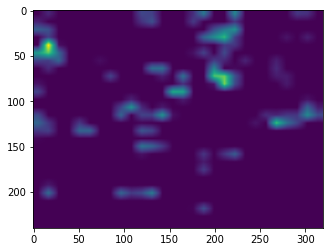

In [349]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image3)
plt.show()

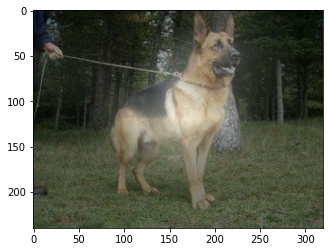

In [350]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([(grad_cam_image5)*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [351]:
rect = get_bbox(grad_cam_image5)
rect

array([[  0,   0],
       [287,   0],
       [287, 184],
       [  0, 184]])

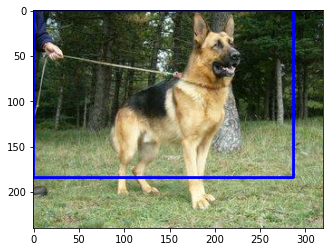

In [352]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [353]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.0, 0.7666666666666667, 0.896875]

In [354]:
item['objects']['bbox']

array([[0.     , 0.23125, 0.925  , 0.73125]], dtype=float32)

In [ ]:
#iou 계산

In [355]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4999320705602035

In [ ]:
#라벨 데이터와 비교

In [356]:
green_bbox = (item['objects']['bbox']*255)[0]

In [357]:
green_bbox = [(green_bbox[0],green_bbox[1]),
                (green_bbox[2],green_bbox[3])]

In [358]:
green_bbox

[(0.0, 58.96875), (235.875, 186.46875)]

In [359]:
for idx, i in enumerate(green_bbox):
    green_bbox[idx] = list(map(int, i)) 

In [360]:
green_bbox

[[0, 58], [235, 186]]

In [361]:
img = cv2.rectangle(image, green_bbox[0], green_bbox[1], (0,255,0), 3)

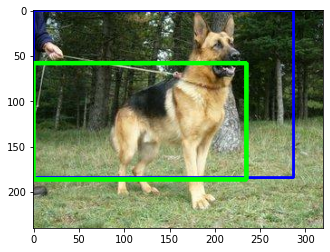

In [362]:
plt.imshow(img)
plt.show()